# Лабораторная работа №6
**Выполнили:**  
Мушкарина Валерия Дмитриевна  
Никитина Евгения Вячеславовна  
Остроушко Егор Игоревич  
ИУ10-94

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import requests
from io import BytesIO

import copy
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from nltk.tokenize import WordPunctTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

### Данные

Мы имеем дело с данными с торговой платформы Avito.
Для каждого товара представлены следующие параметры:
 - title
 - description
 - Category_name
 - Category

Имеется информация об объектах 50 классов.
Задача: по новым объектам (title, description) предсказать Category.
(Очевидно, что параметр Category_name для предсказания классов использовать нельзя)

In [2]:
data = pd.read_csv("train_subset.csv", index_col='id')
data.head()

,title,description,Category_name,Category
id,,,,
382220,Прихожая,В хорошем состоянии. Торг,Мебель и интерьер,20
397529,Кордиант 215/55/16 Летние,Кордиант 215/55/16 Летние/\n /\nАртикул: 1737l...,Запчасти и аксессуары,10
584569,Стол,"Стол, 2 рабочих места . Стол серого цвета, в д...",Мебель и интерьер,20
2513100,Комбинезон,Размер-42/44,"Одежда, обувь, аксессуары",27
1091886,Ветровка,На 2 года,Детская одежда и обувь,29


In [3]:
data.shape

(30000, 4)

In [4]:
X = data[['title', 'description']].to_numpy()
y = data['Category'].to_numpy()

del data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
X_train[:5]

array([['Сапоги 46 размер новые', 'Сапоги 46 размер новые'],
       ['Светильники потолочный swarovski',
        'светильники потолочные swarovski 6 штук , цена за штуку. В эксплуатации 2 года , продаются в связи со сменой интерьера в квартире'],
       ['iPhone 7 plus 128GB Red красный в наличии',
        '\xa0/\n/\n Данная цена только для подписчиков Instagram: iQmac/\n/\n Новый красный айфон 7 Plus в наличии это элегантный и мощный смартфон, который готов в полной мере раскрыть новые возможности iOS 10. Аппарат с 4-ядерным процессором А10 и 3 ГБ ОЗУ с легкостью решает самые ресурсоемкие задачи, позволяя наслаждаться быстродействием «тяжелых» приложений и игр на 5,5-дюймовом дисплее. Аппарат получил экран, как у iPad Pro, так что картинка теперь соответствует кинематографическому стандарту.'],
       ['Пион Ирис Ромашка рассада',
        'Пион куст 500 р ( более 10 шт)/\nСаженец/ корень 100р/\nРастут у нас более 70 лет/\nРозовые, бордовые и белые/\nНа фото цветы 2018г/\nП. Зубчанинов

**Токенизация**


Токенизация -- разбиение текста на мелкие части, которые можно обработать машинными методами.
Можно использовать разные алгоритмы токенизации.
Пока остановимся на простом WordPunctTokenizer.


In [7]:
tokenizer = WordPunctTokenizer()
def preprocess(text: str) -> str:
    return ' '.join(tokenizer.tokenize(text.lower()))

Токенизируем title и description в train и test

In [8]:
len_train = len(X_train)
len_test = len(X_test)
X_train_dt = [0]*len_train
X_test_dt = [0]*len_test

In [9]:
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        X_train[i][j] = preprocess(X_train[i][j])
for i in range(len(X_test)):
    for j in range(len(X_test[i])):
        X_test[i][j] = preprocess(X_test[i][j])
for i in tqdm(range(len_train)):
    X_train_dt[i] = X_train[i][0]+ ' ' + X_train[i][1] 
for i in tqdm(range(len_test)):
    X_test_dt[i] = X_test[i][0]+ ' ' + X_test[i][1] 

100%|██████████| 9000/9000 [00:00<00:00, 479422.08it/s]


In [10]:
X_train[:5]

array([['сапоги 46 размер новые', 'сапоги 46 размер новые'],
       ['светильники потолочный swarovski',
        'светильники потолочные swarovski 6 штук , цена за штуку . в эксплуатации 2 года , продаются в связи со сменой интерьера в квартире'],
       ['iphone 7 plus 128gb red красный в наличии',
        '/ / данная цена только для подписчиков instagram : iqmac / / новый красный айфон 7 plus в наличии это элегантный и мощный смартфон , который готов в полной мере раскрыть новые возможности ios 10 . аппарат с 4 - ядерным процессором а10 и 3 гб озу с легкостью решает самые ресурсоемкие задачи , позволяя наслаждаться быстродействием « тяжелых » приложений и игр на 5 , 5 - дюймовом дисплее . аппарат получил экран , как у ipad pro , так что картинка теперь соответствует кинематографическому стандарту .'],
       ['пион ирис ромашка рассада',
        'пион куст 500 р ( более 10 шт )/ саженец / корень 100р / растут у нас более 70 лет / розовые , бордовые и белые / на фото цветы 2018г / п .

### BOW

Один из традиционных подходов -- построение bag of words.

Метод состоит в следующем:

 - Составим словарь самых часто встречающихся слов в train data
 - Для каждого примера из train посчитаем, сколько раз каждое слово из словаря в нём встречается

In [20]:
bow_vocabulary = []
support_dict = {}
for i in X_train:
    for j in i:
        for k in list(j.split()):
            try:
                support_dict[k] += 1
            except:
                support_dict.update({k:1})
sup_list = list(support_dict.items())
sup_list.sort(key=lambda x: x[1], reverse=True)
for i in range(10000):
    bow_vocabulary.append(sup_list[i][0])

In [14]:
def text_to_bow(text: str) -> np.array:
    """
    Возвращает вектор, где для каждого слова из most_common
    указано количество его употреблений
    """ 
    global result
    result = [0]*10000
    for i in list(text.split()):
        if i in bow_vocabulary:
            result[int(bow_vocabulary.index(i))] = list(text.split()).count(i)
    return np.array(result)

In [15]:
def items_to_bow(items: np.array) -> np.array:
    """ Для каждого товара возвращает вектор его bow """
    # Давайте для начала попробуем строить bow только из description товара
    # assert ниже написан для bow из description
    matrix = [0]*len(items)
    for i in tqdm(range(len(items))):
          matrix[i] = text_to_bow(items[i][1])
    return np.array(matrix)

In [16]:
X_train_bow = items_to_bow(X_train)
X_test_bow = items_to_bow(X_test)

100%|██████████| 9000/9000 [00:46<00:00, 193.98it/s]


### Логистическая регрессия и SVC 


Теперь описание каждого товара представлено, как точка в многомерном пространстве.

Для BOW каждое измерение в пространстве -- какое-то слово.
Мы предполагаем, что текст описывается набором каких-то популярных слов, которые в нём встречаются, а близкие по смыслу тексты будут использовать одинаковые слова.

Обучим логистическую регрессию и SVC с базовыми параметрами.


In [17]:
bow_model = LogisticRegression().fit(X_train_bow, y_train)
print(accuracy_score(bow_model.predict(X_test_bow), y_test))

0.7011111111111111


In [18]:
bow_model = LinearSVC().fit(X_train_bow, y_train)
print(accuracy_score(bow_model.predict(X_test_bow), y_test))

0.6843333333333333


### Модификация признаков 

Добавим title товара в bow с произвольным весом

In [19]:
def items_title_to_bow(items: np.array) -> np.array:
    """ Для каждого товара возвращает вектор его bow """
    # Для начала попробуем строить bow только из description товара
    matrix = [0]*len(items)
    for i in range(len(items)):
        matrix[i] = text_to_bow(items[i][0])
    return np.array(matrix)

X_train_title_bow = items_title_to_bow(X_train)
X_test_title_bow = items_title_to_bow(X_test)

New_train = X_train_title_bow + X_train_bow
New_test = X_test_title_bow + X_test_bow
bow_model = LogisticRegression().fit(New_train, y_train)
print(accuracy_score(bow_model.predict(New_test), y_test))
bow_model = LinearSVC().fit(New_train, y_train)
print(accuracy_score(bow_model.predict(New_test), y_test))

0.7812222222222223
0.7537777777777778


Качество увеличилось значительно так как обучение проходит по большему колличеству слов описывающих товар 

Нормализуем данные (`sklearn.preprocessing.normalize`) перед обучением.

In [20]:
New_train = normalize(New_train)
New_test = normalize(New_test)
bow_model = LogisticRegression().fit(New_train, y_train)
print(accuracy_score(bow_model.predict(New_test), y_test))
bow_model = LinearSVC().fit(New_train, y_train)
print(accuracy_score(bow_model.predict(New_test), y_test))

0.677
0.7987777777777778


Возможно, из-за того что мы исключаем масштабирование признаков, уменьшается отступ между разделяющей гиперплоскостью и объектами,
но в svc существуют вспомогательные гиперплоскости для решения проблем с этим отступом, поэтому svc показывает лучший accuracy, нежели лог регрессия при нормализации

### TF-IDF

Не все слова полезны одинаково, давайте попробуем взвесить их, чтобы отобрать более полезные.


> TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).
> 
> IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [36]:
# Давайте для простоты считать один tf-idf для title и description.
# Для каждого слова из bow_vocabulary нужно посчитать
# в тексте скольких товаров встретилось это слово
new_train_list_tfidf = []
new_test_list_tfidf = []
for i in range(len(X_train)):
    k = preprocess(X_train[i][0]).split()
    k.extend((preprocess(X_train[i][1])).split())
    new_train_list_tfidf.append(k)
for i in range(len(X_test)):
    k = preprocess(X_test[i][0]).split()
    k.extend((preprocess(X_test[i][1])).split())
    new_test_list_tfidf.append(k)

In [37]:
counter = 0
count_arr = {}
for i in tqdm(bow_vocabulary):
    for j in new_train_list_tfidf:
        if i in j:
            counter += 1
    count_arr.update({i: counter})
    counter = 0

100%|██████████| 10000/10000 [03:59<00:00, 41.75it/s]


In [38]:
def text_to_tfidf(text: str, len_doc: int) -> np.array:
    """
    Возвращает вектор, где для каждого слова из most_common
    указан tf-idf
    """
    tf = np.zeros(10000)
    idf = np.zeros(10000)
    new_text = text.split()
    for i in new_text:
        if i in bow_vocabulary:
            tf[bow_vocabulary.index(i)] = new_text.count(i) / len(new_text)
            idf[bow_vocabulary.index(i)] = len_doc / count_arr[i]
 
    return np.array(tf*idf)

In [39]:
tfidf_train = []
tfidf_test = []
for i in tqdm(range(len_train)):
    tfidf_train.append(text_to_tfidf(X_train_dt[i], len_train))
for i in tqdm(range(len_test)):
    tfidf_test.append(text_to_tfidf(X_test_dt[i], len_test))

100%|██████████| 9000/9000 [00:55<00:00, 161.86it/s]


In [40]:
tfidf_train = normalize(tfidf_train)
tfidf_test = normalize(tfidf_test)

### Модели на TF-IDF признаках

Обучим логистическую регрессию и SVC

In [41]:
bow_model = LogisticRegression().fit(tfidf_train, y_train)
print(accuracy_score(bow_model.predict(tfidf_test), y_test))
bow_model = LinearSVC().fit(tfidf_train, y_train)
print(accuracy_score(bow_model.predict(tfidf_test), y_test))

0.6882222222222222
0.7143333333333334


метод малоэффективен на этих данных.

### Word Vectors 
Давайте попробуем другой подход - каждому слову сопоставим какой-то эмбеддинг (вектор).

Вектора будут небольшой размерности. Таким образом мы снизим количество параметров в модели.

Вектора мы возьмём уже готовые (обученные на текстах их интернета), так что наша модель будет знать некоторую дополнительную информацию о внешнем мире.

In [11]:
!wget https://www.dropbox.com/s/0x7oxso6x93efzj/ru.tar.gz

--2020-12-06 21:24:20--  https://www.dropbox.com/s/0x7oxso6x93efzj/ru.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0x7oxso6x93efzj/ru.tar.gz [following]
--2020-12-06 21:24:20--  https://www.dropbox.com/s/raw/0x7oxso6x93efzj/ru.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc531b021fd0cc1c82b56625f804.dl.dropboxusercontent.com/cd/0/inline/BEkzYiWu0a7983JB3JAMlQbfQSZ9R5MM2FAaewdqpb50eaLWNEliIqi5M27pZ70_p6tdEfVckuISyu-9RTouCGfqxnIdo2ZrWpzzpbI1-eM4lA/file# [following]
--2020-12-06 21:24:21--  https://uc531b021fd0cc1c82b56625f804.dl.dropboxusercontent.com/cd/0/inline/BEkzYiWu0a7983JB3JAMlQbfQSZ9R5MM2FAaewdqpb50eaLWNEliIqi5M27pZ70_p6tdEfVckuISyu-9RTouCGfqxnIdo2ZrWpzzpbI1-eM4lA/file
Resolving uc531b021fd0cc1c82

In [12]:
!tar -xzvf ru.tar.gz

ru.bin
ru.vec


In [13]:
import gensim
from gensim.models.wrappers import FastText


model = FastText.load_fasttext_format('ru.bin')

In [14]:
# Эмбеддинг предложения -- сумма эмбеддингов токенов


def sentence_embedding(sentence: str) -> np.array:
    """
    Складывает вектора токенов строки sentence
    """

    embedding_dim = model['кек'].shape[0]
    features = np.zeros([embedding_dim], dtype='float32')
    
    for word in sentence.split():
        if word in model:
            features += model[word]
    
    return features

In [15]:
# Обучите логистическую регрессию и SVM
# Оцените качество (accuracy_score)
New_train_wv = [0]*len_train
New_test_wv = [0]*len_test

for i in range(len_train):
    New_train_wv[i] = sentence_embedding(X_train_dt[i])
for i in range(len_test):
    New_test_wv[i] = sentence_embedding(X_test_dt[i])

In [16]:
wv_model = LogisticRegression(max_iter=100).fit(New_train_wv, y_train)
print(accuracy_score(wv_model.predict(New_test_wv), y_test))
wv_model = LinearSVC(max_iter=70).fit(New_train_wv, y_train)
print(accuracy_score(wv_model.predict(New_test_wv), y_test))

0.5548888888888889
0.5436666666666666


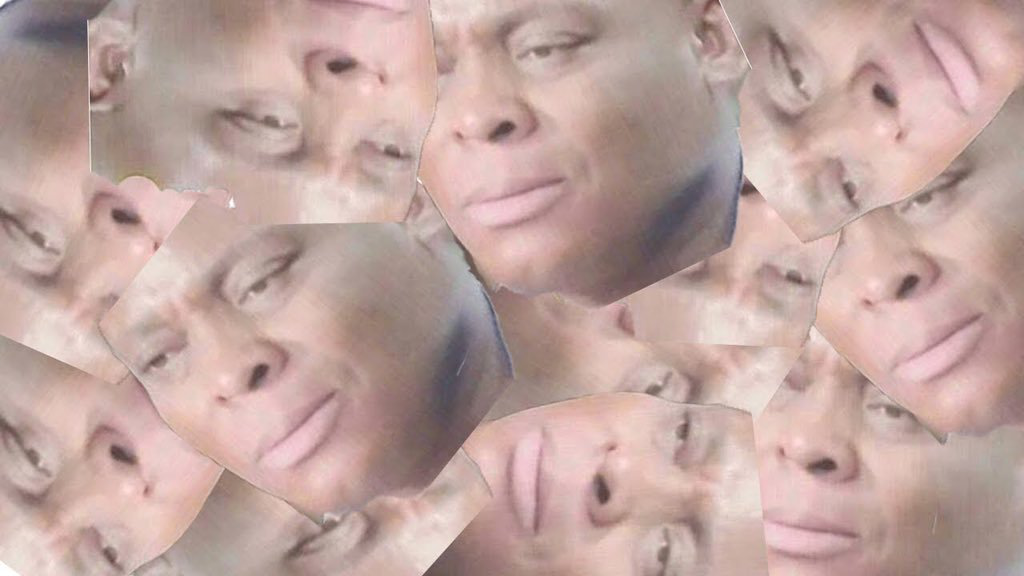

In [17]:
response = requests.get("https://pbs.twimg.com/media/EImSej_XkAAdBoB.jpg")
Image.open(BytesIO(response.content))